In [1]:
%matplotlib
import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, add_self_loops

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as spio
import networkx as nx

import os
os.chdir("../")

import sys
sys.path.append('../scripts')

from eval_link_prediction import accuracy, precision, recall

from link_prediction import negative_sampling, balanced_samples

Using matplotlib backend: agg


## GNN

In [2]:
class NaiveConv(torch.nn.Module):
    def __init__(self, in_channel, out_channel):
        super(NaiveConv, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(in_channel, out_channel),
            torch.nn.Tanh()
        )
        
    def forward(self, x, adj):
        h = self.layers(x)
        x = torch.mm(
            adj,
            h
        )
        return x

    
class Net(torch.nn.Module):
    def __init__(self, in_dim, out_dim, data):
        super(Net, self).__init__()
        self.conv1 = NaiveConv(in_dim, 16)
        self.conv2 = NaiveConv(16, out_dim)
        
        # predict exists or not
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2 * out_dim, 50),
            torch.nn.ELU(),
            torch.nn.Linear(50, 1),
            torch.nn.Sigmoid()
        )
        
        # link injection initialized
        injection = torch.ones_like(data.adj) * 0.01
#         injection = torch.abs(injection)
        self.injection = torch.nn.Parameter(
            injection, 
            requires_grad=True
        )

    def forward(self, data, query_index):
        x, adj = data.x, data.adj
        
        # link injection
        injection = F.relu(self.injection)
        adj = adj + injection
        adj = torch.clamp(adj, 0, 1)
        
        # generate node embeddings
        emb = self.conv1(x, adj)
        emb = F.relu(emb)
        emb = F.dropout(emb, p=0.5, training=self.training)
        emb = self.conv2(emb, adj)
        
        # get queried embeddings
        emb_query = torch.cat((emb[query_index[0]], emb[query_index[1]]), dim=1)
        
        # using embeddings to get score out
        score = self.layers(emb_query)
        
        return score
    
    def get_weight(self, data, query_index):
        adj = data.adj.detach()
        
        # link injection
        injection = F.relu(self.injection.detach())
        adj = adj + injection
        adj = torch.clamp(adj, 0, 1)
        
        # weight
        weights = adj[query_index[0], query_index[1]].view(-1, 1)
        return weights

## Split Dataset

In [3]:
# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# load data
name = 'Cora'
dataset = Planetoid('../datasets/'+ name, name=name)
data = dataset.data

# random sampling edges
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

# split edges
edges = data.edge_index.detach().cpu().numpy().T
edge_train, edge_test = train_test_split(edges, train_size=train_frac, random_state=42)
edge_val, edge_test = train_test_split(
    edge_test, 
    train_size=val_frac/(test_frac + val_frac), 
    random_state=42
)

# create train, validation, test positive edges
data.edge_train = torch.Tensor(edge_train).long().t()
data.edge_val = torch.Tensor(edge_val).long().t()
data.edge_test = torch.Tensor(edge_test).long().t()
data.y_train = torch.ones(len(edge_train), 1).long().t()
data.y_val = torch.ones(len(edge_val), 1).long().t()
data.y_test = torch.ones(len(edge_test), 1).long().t()

# create adjacency matrix
data.adj = to_dense_adj(add_self_loops(data.edge_train)[0])[0]

# to device (GPU default)
data = dataset.data.to(device)

# record the 
num_nodes = data.x.shape[0]
num_edges = data.edge_index.shape[1]
num_train = len(data.edge_train.t())
num_val = len(data.edge_val.t())
num_test = len(data.edge_test.t())

print('Number of nodes =', num_nodes)
print('Number of edges =', num_edges)
print('Training edges =', num_train)
print('Validation edges =', num_val)
print('Test edges =', num_test)

Number of nodes = 2708
Number of edges = 10556
Training edges = 8444
Validation edges = 1056
Test edges = 1056


## Compile Model

In [4]:
from tqdm import tqdm

NUMEPOCHS = 30000
early_stop_win_size = 100
tolerance = 1.00

# compile model
in_dim = data.x.shape[1]

model = Net(
    in_dim,
    50,
    data
).to(device)

optimizer = torch.optim.Adamax(model.parameters(), weight_decay=1e-4)

criterion = torch.nn.modules.loss.BCELoss()

# Training

In [5]:
# get the initial injection
injection_init = F.relu(model.injection.detach() - data.adj.detach())
injection_init = injection_init.cpu().numpy()

In [6]:
# record accuracy
train_loss = np.zeros(NUMEPOCHS)
val_loss = np.zeros(NUMEPOCHS)
test_loss = np.zeros(NUMEPOCHS)

# tracking injection
injection_sum = np.zeros(NUMEPOCHS)

# negative sampling
edge_test, y_test = balanced_samples(data.edge_test, num_nodes)
y_test_injected = model.get_weight(data, edge_test)

# training start
for epoch in range(NUMEPOCHS):
    # negative sampling
    edge_train, y_train = balanced_samples(data.edge_train, num_nodes)
    edge_val, y_val = balanced_samples(data.edge_val, num_nodes)
    
    # consistent with prediction
    y_train = model.get_weight(data, edge_train)
    
    model.train()
    optimizer.zero_grad()
    out = model(data, edge_train)
    loss = criterion(out, y_train.float())
    loss.backward()
    optimizer.step()
    
    # record the loss
    train_loss[epoch] = loss.item()
    model.eval()
    val_loss[epoch] = criterion(model(data, edge_val), y_val.float()).item()
    test_loss[epoch] = criterion(model(data, edge_test), y_test.float()).item()
    
    # get the injection
    injection = F.relu(model.injection.detach()).cpu().numpy()
    injection_sum[epoch] = np.sum(injection)
    
    if epoch % 500 == 0:
        print(
            epoch, 
            ', train loss =', loss.item(),
            ', val loss =', val_loss[epoch], 
        )

0 , train loss = 0.928892195224762 , val loss = 4.6113505363464355
500 , train loss = 0.4601781368255615 , val loss = 0.6624467968940735
1000 , train loss = 0.41642019152641296 , val loss = 0.7132017612457275
1500 , train loss = 0.3918812870979309 , val loss = 0.8860703706741333
2000 , train loss = 0.31270983815193176 , val loss = 0.6935852766036987
2500 , train loss = 0.21016469597816467 , val loss = 0.5441364049911499
3000 , train loss = 0.19397549331188202 , val loss = 0.5271309614181519
3500 , train loss = 0.17116087675094604 , val loss = 0.5071185827255249
4000 , train loss = 0.1585303097963333 , val loss = 0.5210919976234436
4500 , train loss = 0.13116596639156342 , val loss = 0.46270033717155457
5000 , train loss = 0.10949841886758804 , val loss = 0.5476177334785461
5500 , train loss = 0.10158112645149231 , val loss = 0.4813981056213379
6000 , train loss = 0.08923893421888351 , val loss = 0.4637029767036438
6500 , train loss = 0.07920105755329132 , val loss = 0.4511968791484833


In [7]:
# get the initial injection
injection_final = F.relu(model.injection.detach() - data.adj.detach())
injection_final = injection_final.cpu().numpy()

# Evaluation

In [8]:
print('Initial injection = \n', injection_init)
print('\nSum inital = %d\n' % np.sum(injection_init))
print('Final injection = \n', injection_final)
print('\nSum final = %d\n' % np.sum(injection_final))

Initial injection = 
 [[0.   0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.   0.01 ... 0.01 0.01 0.01]
 [0.01 0.   0.   ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.   0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.   0.  ]
 [0.01 0.01 0.01 ... 0.01 0.   0.  ]]

Sum inital = 73221

Final injection = 
 [[0.         0.         0.         ... 0.00214554 0.01956784 0.0173262 ]
 [0.01854607 0.         0.00516123 ... 0.         0.00325348 0.01227781]
 [0.         0.         0.         ... 0.         0.         0.00860801]
 ...
 [0.01141749 0.         0.         ... 0.         0.01178145 0.        ]
 [0.00938036 0.00485132 0.         ... 0.         0.         0.        ]
 [0.01384225 0.         0.         ... 0.         0.         0.        ]]

Sum final = 20629



In [26]:
if False:
    np.save('../variables/injection_sum_gnn', injection_sum)
    np.save('../variables/injection_final_gnn', injection_final)
    np.save('../variables/injection_init_gnn', injection_init)

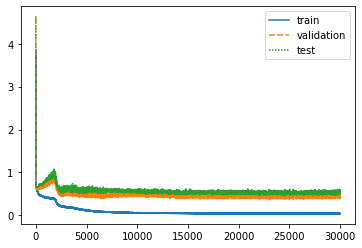

In [9]:
# loss curve
df_acc = pd.DataFrame({
    'train': train_loss,
    'validation': val_loss,
    'test': test_loss
})

sns.lineplot(data=df_acc)
plt.show()

In [10]:
edge_train, y_train = balanced_samples(data.edge_train, num_nodes)
edge_val, y_val = balanced_samples(data.edge_val, num_nodes)
edge_test, y_test = balanced_samples(data.edge_test, num_nodes)

train_score = model(data, edge_train).detach().cpu().numpy().ravel()
val_score = model(data, edge_val).detach().cpu().numpy().ravel()
test_score = model(data, edge_test).detach().cpu().numpy().ravel()

train_pred = (train_score > 0.5).astype(np.int8)
val_pred = (val_score > 0.5).astype(np.int8)
test_pred = (test_score > 0.5).astype(np.int8)

print('Train Accuracy: {:.4f}'.format(accuracy(train_pred, y_train)))
print('Validation Accuracy: {:.4f}'.format(accuracy(val_pred, y_val)))
print('Test Accuracy: {:.4f}'.format(accuracy(test_pred, y_test)))

print('Train Precision: {:.4f}'.format(precision(train_pred, y_train)))
print('Validation Precision: {:.4f}'.format(precision(val_pred, y_val)))
print('Test Precision: {:.4f}'.format(precision(test_pred, y_test)))

print('Train Recall: {:.4f}'.format(recall(train_pred, y_train)))
print('Validation Recall: {:.4f}'.format(recall(val_pred, y_val)))
print('Test Recall: {:.4f}'.format(recall(test_pred, y_test)))

Train Accuracy: 0.9945
Validation Accuracy: 0.9380
Test Accuracy: 0.9252
Train Precision: 0.9893
Validation Precision: 0.9957
Test Precision: 0.9880
Train Recall: 0.9998
Validation Recall: 0.8797
Test Recall: 0.8608


In [11]:
test_acc_all = np.array([0.9228, 0.9403, 0.9328, 0.9266, 0.9351])
test_precision_all = np.array([0.9880, 0.9755, 0.9579, 0.9798, 0.9772])
test_recall_all = np.array([0.8561, 0.9034, 0.9053, 0.8712, 0.8911])

print(np.mean(test_acc_all))
print(np.mean(test_precision_all))
print(np.mean(test_recall_all))

print(np.std(test_acc_all))
print(np.std(test_precision_all))
print(np.std(test_recall_all))

0.9315200000000001
0.97568
0.8854200000000001
0.006193351273745123
0.009871453793641549
0.01904010504172706


In [12]:
print('$%.2f\pm%.2f$' % (np.mean(test_acc_all) * 100, np.std(test_acc_all) * 100), end=" ")
print('$%.2f\pm%.2f$' % (np.mean(test_precision_all) * 100, np.std(test_precision_all) * 100), end=" ")
print('$%.2f\pm%.2f$' % (np.mean(test_recall_all) * 100, np.std(test_recall_all) * 100), end=" ")

$93.15\pm0.62$ $97.57\pm0.99$ $88.54\pm1.90$ 

[[1476  404]
 [1476 1170]
 [2058 2150]
 ...
 [ 513 2612]
 [2212  833]
 [  55 1421]]
[0.12227926 0.11040787 0.11024227 ... 0.02974832 0.02974819 0.02974812]
(10556, 2)
(10556,)


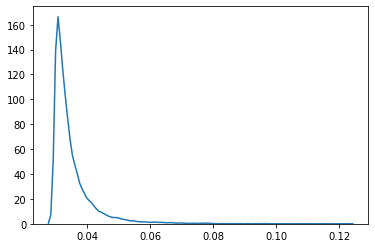

In [13]:
# get non-zero injected links
indexes = injection_final.nonzero()
index_arr = np.stack(indexes)
values = injection_final[indexes]

# sort injected links
sorted_idx = np.flip(np.argsort(values))

sorted_index = index_arr[:, sorted_idx]
sorted_values = values[sorted_idx]

# get the largest N out
num_edges = data.edge_index.size(1)
pred_index = sorted_index[:, :num_edges].T
pred_values = sorted_values[:num_edges]
print(pred_index)
print(pred_values)
print(pred_index.shape)
print(pred_values.shape)

sns.distplot(pred_values, hist=False)
plt.show()

In [14]:
if False:
    np.save('../variables/sorted_GNN_injection', sorted_index)
    np.save('../variables/sorted_GNN_weights', sorted_values)

In [15]:
# get the highest score out
print(pred_index[:10])
print(pred_values[:10])

[[1476  404]
 [1476 1170]
 [2058 2150]
 [  92  898]
 [ 123  122]
 [ 117 2537]
 [1737   64]
 [2567  953]
 [ 953 2565]
 [1101 2146]]
[0.12227926 0.11040787 0.11024227 0.10124763 0.10060218 0.09747972
 0.09650449 0.09614945 0.09596185 0.09529198]


### Visualize Top-1 Neighborhood

In [16]:
def show_ego_graph(data, index):
    # convert to graph
    G = torch_geometric.utils.to_networkx(
        dataset.data, node_attrs=None, edge_attrs=None
    )

    # Create ego graph of main hub
    hub_ego = nx.ego_graph(G, index, radius=2)

    # Draw graph
    pos = nx.spring_layout(hub_ego)
    nx.draw(hub_ego, pos, node_color='b', node_size=50, with_labels=False)

    # Draw ego as large and red
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[index], node_size=100, node_color='r')
    plt.show()

def show_link_graph(data, src, dst, numbering=None):
    # convert to graph
    G = torch_geometric.utils.to_networkx(
        dataset.data, node_attrs=None, edge_attrs=None
    )

    # Create ego graph of main hub
    src_ego = nx.ego_graph(G, src, radius=2)
    dst_ego = nx.ego_graph(G, dst, radius=2)
    
    hub_ego = nx.algorithms.operators.binary.compose(src_ego, dst_ego)
    
    f = plt.figure(figsize=(8, 6))
    
    # Draw graph
    pos = nx.spring_layout(hub_ego)
    nx.draw(hub_ego, pos, node_color='b', node_size=50, with_labels=False, alpha=0.2)
    
    # Draw ego as large and red
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[src, dst], node_size=100, node_color='r', alpha=0.8)
    if numbering is None:
        f.savefig("link_graph.pdf", bbox_inches='tight')
    else:
        f.savefig("link_graph_%d.pdf" % numbering, bbox_inches='tight')
    plt.show()

/home/jayroxis/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/jayroxis/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


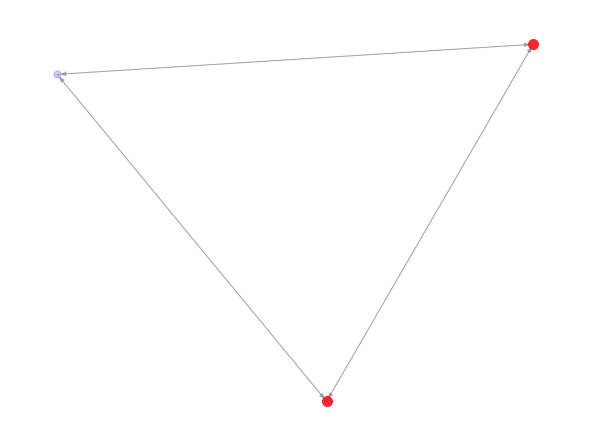

In [17]:
show_link_graph(data, pred_index[0][0], pred_index[0][1])

### Top 50 Shortest Path

In [18]:
G = torch_geometric.utils.to_networkx(
        dataset.data, node_attrs=None, edge_attrs=None
    )

for src, dst in pred_index[:50]:
    if nx.has_path(G, source=src, target=dst):
        shortest_path = nx.shortest_path(G, source=src, target=src)
        print(src, dst, shortest_path, len(shortest_path))
    else:
        print(src, dst, nx.has_path(G, source=src, target=dst))

1476 404 [1476] 1
1476 1170 [1476] 1
2058 2150 [2058] 1
92 898 [92] 1
123 122 [123] 1
117 2537 [117] 1
1737 64 [1737] 1
2567 953 [2567] 1
953 2565 [953] 1
1101 2146 [1101] 1
857 963 [857] 1
1114 2560 [1114] 1
230 396 [230] 1
108 1504 [108] 1
1115 963 [1115] 1
785 455 [785] 1
2567 2566 [2567] 1
1310 2692 [1310] 1
2486 2513 [2486] 1
885 299 [885] 1
123 2454 [123] 1
2122 1098 [2122] 1
1684 2486 [1684] 1
1371 1393 [1371] 1
2429 250 [2429] 1
1434 909 [1434] 1
2373 670 [2373] 1
1301 17 [1301] 1
1250 353 [1250] 1
123 99 [123] 1
1718 632 [1718] 1
1731 1114 [1731] 1
1290 2258 [1290] 1
1439 200 [1439] 1
2122 2065 [2122] 1
644 2367 [644] 1
122 123 [122] 1
2105 517 [2105] 1
1473 2706 [1473] 1
785 2147 [785] 1
417 2495 [417] 1
2479 1236 [2479] 1
1222 925 [1222] 1
2646 1050 [2646] 1
1837 182 [1837] 1
2038 293 [2038] 1
1993 577 [1993] 1
208 7 [208] 1
127 123 [127] 1
836 2402 [836] 1


### Top Injected Links (Predicted Use Link Injection)

In [19]:
path_length = []
src_list, dst_list = [], []

for src, dst in pred_index:
    src_list.append(src)
    dst_list.append(dst)
    if nx.has_path(G, source=src, target=dst):
        shortest_path = nx.shortest_path(G, source=src, target=src)
        path_length.append(len(shortest_path))
    else:
        path_length.append(0)
        
path_length = np.array(path_length)

In [20]:
num_pred = pred_index.shape[0]

direct_link = np.sum(path_length == 1) / num_pred # directed connected,i.e., neighbors
indirect_link = np.sum(path_length > 1)/ num_pred # have a path between but not neighbors
unconnected = np.sum(path_length == 0) / num_pred # directed connected,i.e., neighbors
unconnected_pos = np.where(path_length == 0)[0]

print(direct_link)
print(indirect_link)
print(unconnected)
print(np.mean(unconnected_pos))

0.7773777946191739
0.0
0.22262220538082608
6044.1757446808515


In [21]:
0.8691739295187572 * 10556

9175.0

221 [1358 2225]
tensor(2, device='cuda:0') tensor(4, device='cuda:0')


/home/jayroxis/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/jayroxis/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


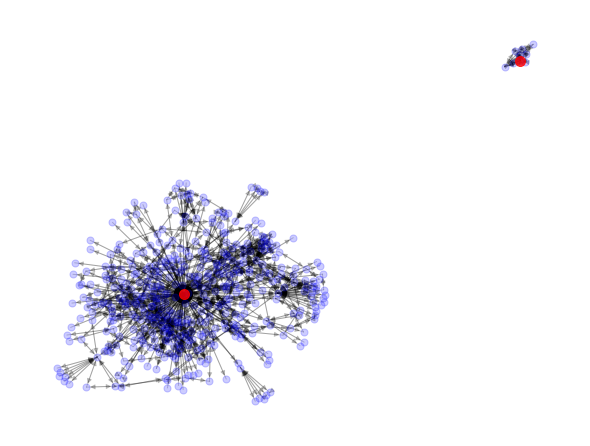

244 [702  99]
tensor(6, device='cuda:0') tensor(6, device='cuda:0')


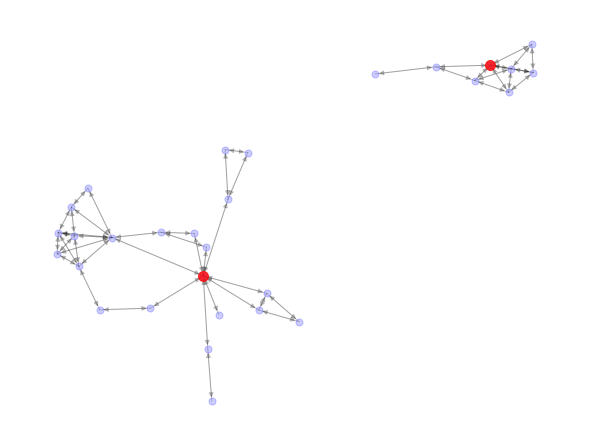

250 [1358 2224]
tensor(2, device='cuda:0') tensor(4, device='cuda:0')


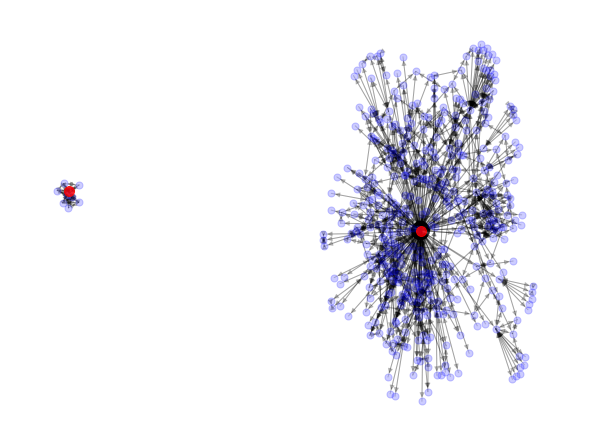

282 [1358  284]
tensor(2, device='cuda:0') tensor(4, device='cuda:0')


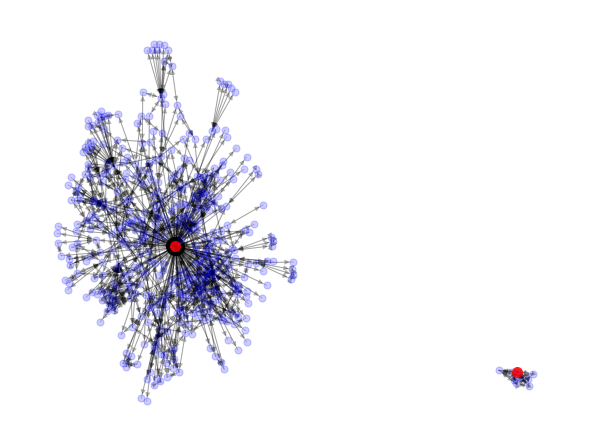

329 [1103 2604]
tensor(2, device='cuda:0') tensor(6, device='cuda:0')


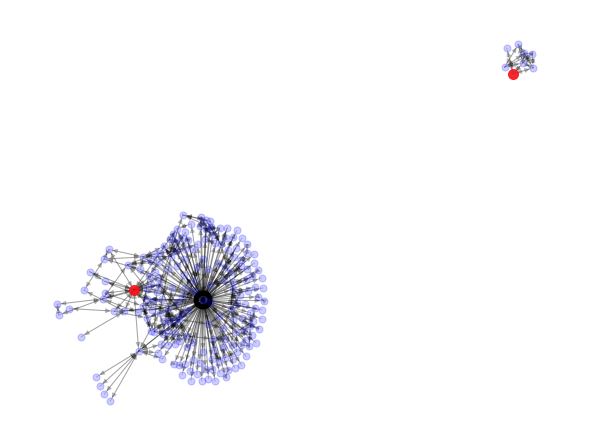

In [29]:
for i in range(5):
    idx = unconnected_pos[i]
    print(idx, pred_index[idx])
    src = pred_index[idx][0]
    dst = pred_index[idx][1]
    print(data.y[src], data.y[dst])
    show_link_graph(data, src, dst, numbering=i+1)

### Link Injected (Not In Training Set) Found in Orginal Graph

In [23]:
# find out how many injected links are in the graph
true_index = data.edge_index.cpu().numpy().T

start = true_index[:, 0]

unq_val, unq_idx = np.unique(start, return_index=True)
start_dict = dict(zip(unq_val, unq_idx))

correct_list = []
for i in range(len(pred_index)):
    pred = pred_index[i]
    if pred[0] in start_dict:
        begin = start_dict[pred[0]]
        if pred[0] + 1 in start_dict:
            end = start_dict[pred[0] + 1]
        else:
            end = len(true_index)
    for j in range(begin, end):
        true = true_index[j]
        if np.array_equal(pred, true):
            print(i, j, pred, true)
            correct_list.append((i, pred))
            break

0 5850 [1476  404] [1476  404]
1 5851 [1476 1170] [1476 1170]
2 8517 [2058 2150] [2058 2150]
3 393 [ 92 898] [ 92 898]
5 533 [ 117 2537] [ 117 2537]
6 6983 [1737   64] [1737   64]
7 10273 [2567  953] [2567  953]
8 3698 [ 953 2565] [ 953 2565]
9 4291 [1101 2146] [1101 2146]
11 4345 [1114 2560] [1114 2560]
17 5094 [1310 2692] [1310 2692]
22 6672 [1684 2486] [1684 2486]
23 5478 [1371 1393] [1371 1393]
24 9887 [2429  250] [2429  250]
29 576 [123  99] [123  99]
32 5013 [1290 2258] [1290 2258]
33 5712 [1439  200] [1439  200]
37 8692 [2105  517] [2105  517]
38 5839 [1473 2706] [1473 2706]
41 10055 [2479 1236] [2479 1236]
42 4755 [1222  925] [1222  925]
45 8418 [2038  293] [2038  293]
47 883 [208   7] [208   7]
50 7273 [1794 1796] [1794 1796]
51 758 [ 168 2438] [ 168 2438]
52 2516 [ 614 1475] [ 614 1475]
57 3869 [ 998 1431] [ 998 1431]
61 9642 [2358 1185] [2358 1185]
65 6044 [1527 1668] [1527 1668]
66 5503 [1381 1794] [1381 1794]
67 10261 [2563 1050] [2563 1050]
68 88 [26 99] [26 99]
69 592 [ 

3333 106 [  31 1594] [  31 1594]
3393 6169 [1554 2687] [1554 2687]
3441 10549 [2706  169] [2706  169]
3467 715 [156 817] [156 817]
3512 47 [  15 1271] [  15 1271]
3528 8877 [2147  374] [2147  374]
3561 440 [  99 2604] [  99 2604]
3565 3210 [ 801 1961] [ 801 1961]
3741 5532 [1392   51] [1392   51]
3795 765 [ 171 1548] [ 171 1548]
3833 4342 [1113  107] [1113  107]
3842 10287 [2573 2570] [2573 2570]
3898 713 [156  90] [156  90]
4128 916 [218 781] [218 781]
4283 10306 [2582    0] [2582    0]
4398 9011 [2180  257] [2180  257]
4459 8982 [2173  939] [2173  939]
4469 7440 [1826 1829] [1826 1829]
4484 4367 [1119 1462] [1119 1462]
4594 651 [144 145] [144 145]
4609 3614 [914 875] [914 875]
4614 2900 [ 729 1221] [ 729 1221]
4715 9584 [2339 2340] [2339 2340]
4826 4217 [1083  321] [1083  321]
4847 3379 [ 849 2351] [ 849 2351]
4920 9753 [2386 1082] [2386 1082]
4942 8170 [1986 1870] [1986 1870]
4948 1536 [376 220] [376 220]
5060 3859 [ 996 1257] [ 996 1257]
5101 9240 [2236  805] [2236  805]
5128 1350 

In [27]:
hit_rate = len(correct_list) / num_edges
print('hits =', len(correct_list))
print('hit rate =', hit_rate)
print('number of top-scored predictions =', len(pred_index))
num_options = len(true_index) ** 2
print('p =', 1 / num_options)
print('significance =', hit_rate * num_options)

MR = np.mean(np.array([item[0] for item in correct_list]))
print('MR =', MR)
print('MR Ratio =', 1 - MR / num_edges)

hits = 385
hit rate = 0.03647214854111406
number of top-scored predictions = 10556
p = 8.974313504503885e-09
significance = 4064060.0
MR = 2193.820779220779
MR Ratio = 0.7921730978381225


In [28]:
print('%.3f\\%%' % (0.038177339901477834 * 5 * 100))

19.089\%
